In [90]:
##########################
studies = [
    { 'study_name' : 'ac2', 'study_time' : 1200 },
    #{ 'study_name' : 'ac2', 'study_time' : 900 },
    { 'study_name' : 'chi19s2', 'study_time' : 900 },
    { 'study_name' : 'chi19s3', 'study_time' : 1500 }
    #{ 'study_name' : 'chi19s3', 'study_time' : 900 }
]
min_idea_submits = 3

# Must not be smaller than sliding_window
bucket_length = 50

# Sliding window defaults to bucket_length if <0
sliding_window = 10



In [69]:
##########################

import pandas as pd
import statistics
import matplotlib.pyplot as plt
import numpy as np


def filter_by_idea_submits(study_name, timer_value, min_idea_submits):
    data = pd.read_csv(study_name + '.csv', sep=';')
    column_name = str(timer_value) + '-ideaSubmitTimers'
    return data[data[column_name] >= min_idea_submits]

def get_median_requests(data, timer_value):
    column_name = str(timer_value) + '-inspirationRequestTimers'
    return statistics.median(data[column_name])   



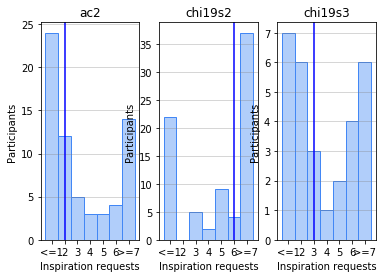

In [91]:
##########################
def print_histogram(study):
    filtered_data = filter_by_idea_submits(study['study_name'], study['study_time'], min_idea_submits)
    med = get_median_requests(filtered_data, study['study_time'])
    
    clipped_data = np.clip(filtered_data[str(study['study_time']) + '-inspirationRequestTimers'], 1, 7)
    plt.hist(clipped_data, bins=np.arange(8)+0.5, color = "#b1cefa", edgecolor='#4287f5')
    xticks =  np.insert(np.append(np.arange(2, 7), ">=7"),0, "<=1" )
    plt.title(study['study_name'])
    plt.xlabel('Inspiration requests')
    plt.ylabel('Participants')
    plt.xticks(np.arange(7) + 1, labels = xticks)
    plt.axvline(med, color = "blue")
    plt.grid(axis='y', alpha = 0.4, color = "gray")

fig = plt.figure()
fig.add_subplot(1,3,1)
print_histogram(studies[0])
fig.add_subplot(1,3,2)
print_histogram(studies[1])
fig.add_subplot(1,3,3)
print_histogram(studies[2])
plt.show()

In [71]:
##########################

def get_types(filtered_data, timer_value):
    median = get_median_requests(filtered_data, timer_value)
    column_name = str(timer_value) + '-inspirationRequestTimers'
    seekers = filtered_data[filtered_data[column_name] > median]["workerId"]
    avoiders = filtered_data[filtered_data[column_name] <= 2]["workerId"]
    return {'seekers': seekers, 'avoiders': avoiders}
    

In [72]:
##########################
def get_events_per_type(study, types):
    submits = pd.read_csv(study['study_name'] + '_ideaSubmits.csv', sep=';')
    requests = pd.read_csv(study['study_name'] + '_inspirationRequests.csv', sep=';')
    return {
        'avoider_submits': submits[submits['workerId'].isin(types['avoiders'])],
        'seeker_submits' : submits[submits['workerId'].isin(types['seekers'])],
        'avoider_requests' : requests[requests['workerId'].isin(types['avoiders'])],
        'seeker_requests' : requests[requests['workerId'].isin(types['seekers'])] 
    }
#seekers.size

# Get sliding-window buckets for each event array:
# Different lengths -> Fill up with zeros? Cut at smallest?
# Worker1: [[0,1,2,3],[1,2,3,4],[2,3,4,5],...]
#            ^^^^^^^^ one bucket

# in seconds

def get_buckets(row):
    i = 0
    result = []
    while i < row.size:
        result.append(row[i:i+bucket_length])
        i = i + (sliding_window if sliding_window > 0 else bucket_length)
    return np.asarray(result)

def get_event_data(event_table):        
    flattened_events = event_table.drop(columns = "workerId")\
        .to_numpy()\
        .flatten()
    #np.vectorize(get_buckets)(d)
    return np.array(get_buckets(flattened_events))

def get_result(events_per_type): 
    return {
        "avoider_submits": get_event_data(events_per_type['avoider_submits']),
        "avoider_requests": get_event_data(events_per_type['avoider_requests']),
        "seeker_submits": get_event_data(events_per_type['seeker_submits']),
        "seeker_requests": get_event_data(events_per_type['seeker_requests']),
    }



In [73]:
def get_results_for_all_studies(): 
    results = {}
    for study in studies:
        filtered_data = filter_by_idea_submits(study['study_name'], study['study_time'], min_idea_submits)
        # TODO: fill data up with 0s
        
        types = get_types(filtered_data, study['study_time'])
        # TODO: Put submit/request in one array
        events_per_type = get_events_per_type(study, types)
        
        result = get_result(events_per_type)
        results[study['study_name']] = result
    return results
    
get_results_for_all_studies()

{'ac2': {'avoider_submits': array([array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0], dtype=int64),
         array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0], dtype=int64),
         array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0], dtype=int64),
         ...,
         array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
         array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        dtype=int64),
         array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)], dtype=object),
  'avoider_requests': array([array([0, 0, 0, 0, 0, 0, 0, 